In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader, TensorDataset
from torch import sigmoid as sig
from delphi import train
import delphi.utils.constants as consts
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

if ch.cuda.is_available(): 
    ch.set_default_tensor_type(ch.cuda.FloatTensor)
    print("cuda tensors...")

cuda tensors...


# Helpers

In [ ]:
EXP_NAME = 'LogisticBCE'
LOG_STORE_PATH = '/home/gridsan/stefanou/LogisticRegression/' + EXP_NAME

## Default Experiment Parameters

In [57]:
# procedure hyperparameters
args = Parameters({ 
    'steps': 1000,
    'workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'samples': 10000,
    'in_features': 2,
    'lower': -1, 
    'upper': 1,
    'samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.CYCLIC,
    'var': True,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'momentum': .9, 
    'weight_decay': 5e-4, 
    'trials': 10,
    'train_split': .8,
    
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
args

{
  "steps": 1000,
  "workers": 0,
  "batch_size": 100,
  "bias": true,
  "num_samples": 100,
  "samples": 1000,
  "in_features": 2,
  "lower": -1,
  "upper": 1,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.1,
  "shuffle": false,
  "tol": 0.01,
  "eps": 1e-05,
  "score": true,
  "custom_lr_multiplier": "cyclic",
  "var": true,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "momentum": 0.9,
  "weight_decay": 0.0005,
  "trials": 10,
  "train_split": 0.8,
  "device": "cuda"
}

# Logistic BCE

In [58]:
class LogisticBCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.BCEWithLogitsLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors

        # logistic distribution
        base_distribution = Uniform(0, 1)
        transforms_ = [SigmoidTransform().inv]
        logistic = TransformedDistribution(base_distribution, transforms_)

        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)
        rand_noise = logistic.sample(stacked.size())
        # add noise
        noised = stacked + rand_noise
        noised_labs = noised > 0
        # filter
        mask = (noised_labs).eq(targ)
        inner_sig = (sig(rand_noise))
        avg = 1 - 2*((inner_sig*mask).sum(0) / (mask.sum(0) + 1e-5))
        return -avg, None
    
logistic_bce = LogisticBCE.apply
from torch.nn import BCEWithLogitsLoss; bce_logit = BCEWithLogitsLoss()

# Compare Latent Variable Gradient with LogitsBCE

In [59]:
# generate random uniform weights
W = Uniform(args.lower, args.upper).sample(ch.Size([args.in_features, 1]))
W0 = Uniform(args.lower, args.upper).sample(ch.Size([1, 1]))

# logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

# generate data
X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
z = X.mm(W) + W0 + logistic.sample(ch.Size([X.size(0), 1]))
y = ch.where(z > 0, ch.ones(1), ch.zeros(1))

model = ch.nn.Linear(in_features=2, out_features=1)
pred = model(X)

gt_loss = bce_logit(pred, y)
gt_g, = ch.autograd.grad(gt_loss, [pred])

log_loss = logistic_bce(pred, y)
log_g, = ch.autograd.grad(log_loss, [pred])

print('Cosine Similarity between real and estimated gradient: ',
        ch.nn.CosineSimilarity(dim=1)(log_g.T, gt_g.T))

Cosine Similarity between real and estimated gradient:  tensor([-0.9215])


# LogisticBCE vs BCEWithLogits

In [60]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1)
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

In [56]:
# perform each experiment a total of 10 times
for iter_ in range(args.trials): 
    
    # create store
    store = Store(LOG_STORE_PATH)

    # epoch hooks
    log_epoch_hook =  epoch_hook(store, table_name='log_ground_truth')
    logit_epoch_hook = epoch_hook(store, table_name='logit_ground_truth')
        
    # generate ground-truth from uniform distribution
    ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=1, bias=args.bias)
    ground_truth.weight = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1, args.in_features])))
    if ground_truth.bias is not None: 
        ground_truth.bias = nn.Parameter(Uniform(args.lower, args.upper).sample(ch.Size([1,])))

    # generate data
    X = Uniform(-5, 5).sample(ch.Size([args.samples, args.in_features]))
    z = ground_truth(X) + logistic.sample(ch.Size([args.samples, 1]))
    y = ch.where(z > 0, ch.ones(1), ch.zeros(1))
    
    
    # split data into train and validation sets
    ds = TensorDataset(X, y)
    train_count = int(args.train_split*len(ds))
    val_count = len(ds) - train_count
    loaders = ch.utils.data.random_split(ds, (train_count, val_count))
    
    # run logistic bce
    args.__setattr__('custom_criterion', logistic_bce)
    
    # set ground_truths in epoch hook
    log_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', log_epoch_hook)

    # optimize logistic bce gradient
    log_bce_model = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
    log_bce_model = train.train_model(args, log_bce_model, loaders, store=store)
    
    
    # run bce with logits
    args.__setattr__('custom_criterion', bce_logit)
    # set ground_truths in epoch hook
    logit_epoch_hook.set_ground_truth(ground_truth)
    args.__setattr__('epoch_hook', logit_epoch_hook)
    
    # optimize bce with logits
    logits_model = ch.nn.Linear(in_features=args.in_features, out_features=1, bias=args.bias)
    logits_model = train.train_model(args, logits_model, loaders, store=store)

    # parameter estimates 
    real_params = ch.cat([ground_truth.weight, ground_truth.bias.unsqueeze(0)], axis=1)
    logits_bce_params = ch.cat([logits_model.weight.detach(), logits_model.bias.detach().unsqueeze(0)], axis=1)
    log_bce_params = ch.cat([log_bce_model.weight.detach(), log_bce_model.bias.detach().unsqueeze(0)], axis=1)
        
    IPython.display.clear_output(wait=False)

    # close current store
    store.close()

Logging in: /home/gridsan/stefanou/LogisticRegression/LogisticBCE/990036c8-d2ee-491c-a2bf-9c0b6d0c5063


  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

tensor([[ 0.3501, -0.6290, -0.5746]], grad_fn=<CatBackward>)

# Results

In [46]:
reader = CollectionReader(LOG_STORE_PATH)

log_results = reader.df('log_ground_truth')
logit_results = reader.df('logit_ground_truth')
logs = reader.df('logs')
reader.close() # close reader

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: The file '/home/gridsan/stefanou/LogisticRegression/LogisticBCE/910b0a21-6eb5-4067-858a-329104e34b1e/store.h5' is already opened, but not in read-only mode (as requested).

In [47]:
logit_results.head()

,cos_sim,l2,epoch,exp_id
0,-0.106540,0.402550,1,31731cdc-16f7-4ec9-813a-a45684ee8ebd
0,0.766760,0.117267,1,274c8f4a-e65c-4b9a-ab51-21a74fdffab4
0,-0.376782,1.464030,1,b0eceab8-1f50-4719-b6ec-b94af2f24f2a
0,0.368691,0.255039,1,121a57e6-f312-468f-991a-563f10195c0d
0,0.689585,0.204366,1,52438c22-2df4-47b5-a18e-9ea5d3b810c1


# All Trials

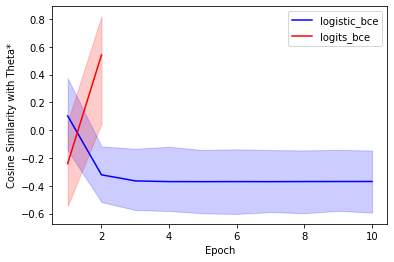

In [30]:
# variance vs param mse
sns.lineplot(data=log_results, x='epoch', y='cos_sim', label='logistic_bce', color='blue')
ax = sns.lineplot(data=logit_results, x='epoch', y='cos_sim', label='logits_bce', color='red')
ax.set(xlabel='Epoch', ylabel='Cosine Similarity with Theta*')
plt.show()

In [66]:
len(results)

80

In [7]:
filtered = Tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

stuff = Tensor([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0]]).eq(Tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0]))[...,None]

stuff * filtered

tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [8]:
stuff

tensor([[[ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [ True],
         [False],
         [ True],
         [ True],
         [ True]]])

In [12]:
1 - ch.exp(-Tensor([-0.2534]))

tensor([-0.2884])

In [36]:
from torch.nn import BCEWithLogitsLoss




In [37]:
X, z, y

(tensor([[ 54.3043, -72.1545],
         [-22.5310,   9.2756],
         [ 58.2956,  90.2150],
         [ 43.9802, -21.3367],
         [  4.7401, -65.6959],
         [ -4.1178, -16.7170],
         [-93.5648,  34.9560],
         [-58.1004,  99.4695],
         [ 37.4152,  -2.5600],
         [-55.5908,  63.1597]]),
 tensor([[  88.4926],
         [ -27.1840],
         [   7.4206],
         [  54.2123],
         [  39.9068],
         [   5.7514],
         [-102.1335],
         [-106.2591],
         [  36.8696],
         [ -83.0426]]),
 tensor([[1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.]]))

Correlation between real and estimated gradient:  tensor(0.9935)


In [59]:
gt_g

tensor([[-0.1000],
        [ 0.0975],
        [ 0.0000],
        [-0.1000],
        [-0.1000],
        [-0.1000],
        [ 0.1000],
        [ 0.1000],
        [-0.0122],
        [ 0.1000]])

In [60]:
log_g

tensor([[ 1.9856],
        [ 1.1565],
        [-0.8731],
        [-1.2506],
        [-0.8169],
        [-2.1066],
        [-1.1343],
        [-0.8081],
        [-1.7252],
        [-0.6086]])

In [68]:

log_loss = logistic_bce(pred, y)
log_g, = ch.autograd.grad(log_loss, [pred])

In [69]:
log_g

tensor([[ 0.0000],
        [ 0.0976],
        [ 0.0073],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [-0.0111],
        [ 0.0000]])